Let's check if solving OCPs the newly generated class for parametrized problems works (currently model interpolation only)

In [1]:
from parametrized_drone_MPC import ParametrizedDroneMPC
import sys
import os
import numpy as np

# Add parent directory of the notebook to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from drone_MPC import DroneMPCOptions

# Same Setup as in original class
l0 = 0.3
M = 2.0
m = 0.3
M_total = M + m
c = 1
g = 9.81
# Required total thrust for hovering T = (M_total)*g, and assuming symmetric rotors, each rotor speed is set to T/2 (with c=1)
w_val = (M_total * g) / (2.0*c)

# Create an instance of the MPC options (using the updated physical parameters)
opts = DroneMPCOptions(
    M=M,         # drone mass in kg
    m=m,         # load mass in kg (small compared to drone)
    Ixx=0.05,      # moment of inertia in kg·m²
    g=g,        # gravitational acceleration in m/s²
    c=c,         # rotor thrust constant
    L_rot=0.2,     # half distance between rotors in m
    k=500.0,       # stiff spring (N/m)
    l0=l0,        # spring rest length in m
    # Constraints and cost weighting matrices remain as defined by default

    N = 300,
    switch_stage = 300,
    step_sizes = [0.01]*300,

    w_min = -2*w_val,
    w_max = 2*w_val,
    w_dot_min = -30,
    w_dot_max = 30,
    phi_min = -np.pi*3/10,
    phi_max = np.pi*3/10,
    F_min = -2*w_val*c,
    F_max = 2*w_val*c,

    integrator_type="ERK",

    create_sim=False # Sim creation code not adapted for parametrized subclass
)

mpc_parametrized = ParametrizedDroneMPC(opts)

x0 = np.array([
    0.0,    # y position
    1.0,    # z position (hover altitude)
    0.0,    # phi (drone pitch)
    l0,     # r (pendulum length set to rest length)
    0.0,    # theta (pendulum angle)
    0.0,    # y_dot
    0.0,    # z_dot
    0.0,    # phi_dot
    0.0,    # r_dot
    0.0,    # theta_dot
    w_val,  # w1 (rotor speed)
    w_val   # w2 (rotor speed)
])
print("Initial hovering state:", x0)

# Define a reference position far away (for example, [10, 10])
pos_ref = np.array([10.0, 2.0])

# set initial guess to avoid division by zero for r
mpc_parametrized.set_initial_guess(x0, u_guess=np.zeros(2))

# Call the MPC solve function to compute the first control input
p = np.zeros(opts.N) # zero parameters 
p[10] = 0.05
u0 = mpc_parametrized.solve(x0, p, pos_ref)
print("First control input:", u0)


rm -f libacados_ocp_solver_drone_full_1743466234100.so
rm -f drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_0_fun.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_0_fun_jac_ut_xt.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_0_hess.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_fun.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_fun_jac_ut_xt.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_hess.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_e_fun.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_e_fun_jac_ut_xt.o drone_full_1743466234100_cost/drone_full_1743466234100_cost_y_e_hess.o acados_solver_drone_full_1743466234100.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

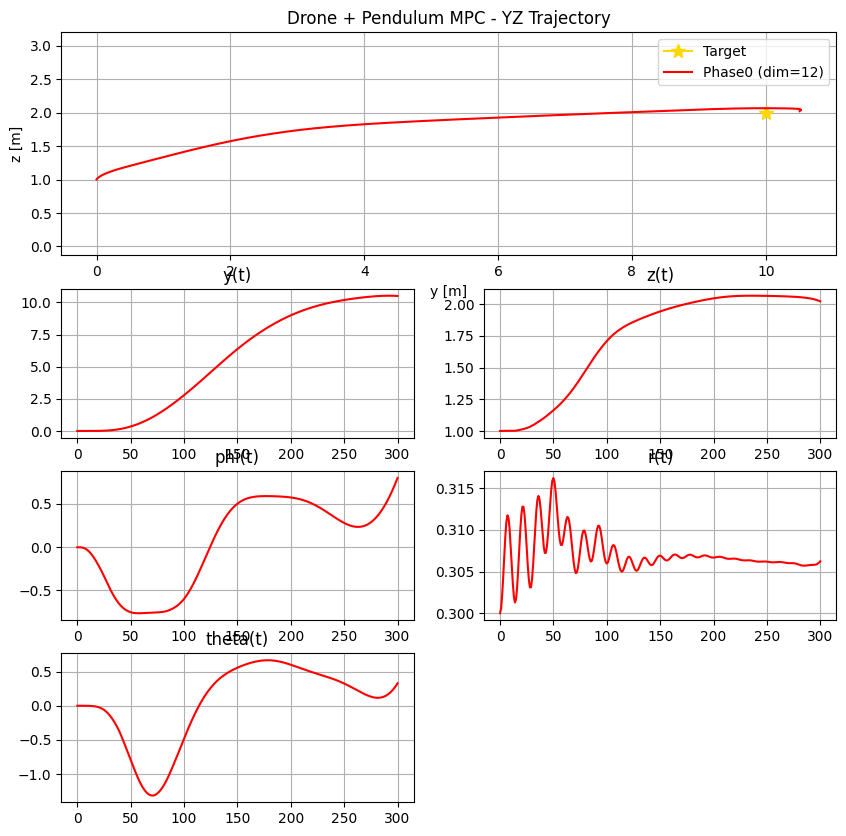

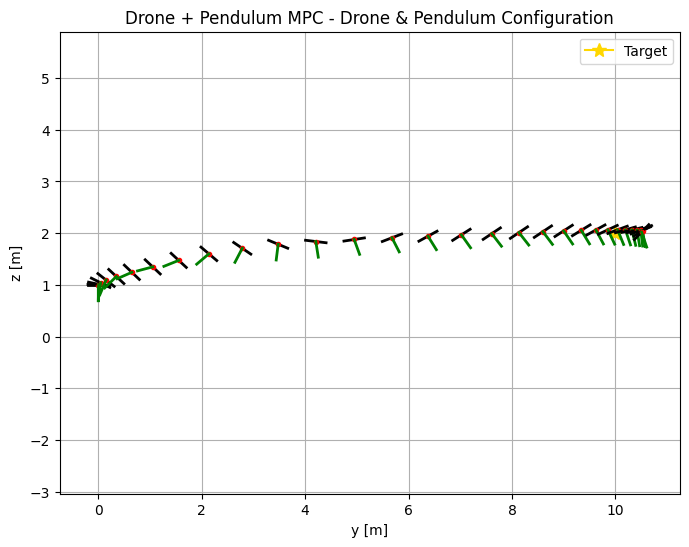

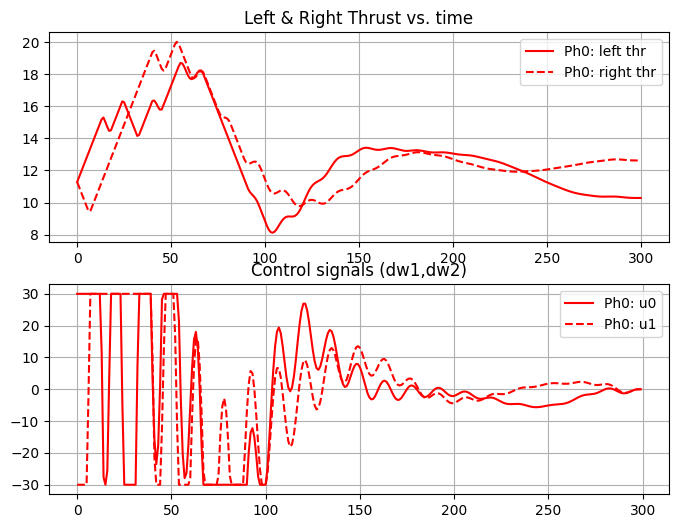

In [2]:
from plotting_utils_drone import plot_drone_mpc_solution

x_traj, u_traj = mpc_parametrized.get_planned_trajectory()

plot_drone_mpc_solution(
    mpc=mpc_parametrized, 
    reference_xy=pos_ref,
    open_loop_plan=x_traj,
    u_traj=u_traj,
    step_pose=10
)

Simulate base MPC in closed loop with the basic MPC.  

In [ ]:
from copy import deepcopy
from drone_MPC import DroneMPC
from utils_drone import simulate_closed_loop_drone

opts_base_mpc = deepcopy(opts)
opts_base_mpc.create_sim = True
mpc_base = DroneMPC(opts_base_mpc)

# (Optional) Set an initial guess for the base MPC
mpc_base.set_initial_guess(x0, u_guess=np.zeros(2))
duration = 4

x_traj, _, _, _ = simulate_closed_loop_drone(
    x0, 
    mpc_base, 
    duration, 
    target_xy=pos_ref,
    stage_cost_function=mpc_base.stage_cost_func_full,
    sigma_noise=0.0,  
    sim_solver=None, 
    control_step=1
)

# Plot the closed-loop simulation result.
plot_drone_mpc_solution(
    mpc=mpc_base, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)

rm -f libacados_ocp_solver_drone_full_1743466299859.so
rm -f drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_0_fun.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_0_fun_jac_ut_xt.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_0_hess.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_fun.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_fun_jac_ut_xt.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_hess.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_e_fun.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_e_fun_jac_ut_xt.o drone_full_1743466299859_cost/drone_full_1743466299859_cost_y_e_hess.o acados_solver_drone_full_1743466299859.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

ValueError: No sim_solver provided, and mpc.sim_solver_full not found.

Ok. Let's compute the Sensitivities w.r.t model switching. For now, we need to do so by finite differences, as acados only supports global parameters, so we are not able to get the sensitivities w.r.t p_i in a given stage. If this is really effective for determining the switching index, I should maybe make an acados PR that extends this, to directly obtain the sensitivities in a quick and cheap way by differentiating the KKT conditions.

# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
0	1.196043e+01	7.532753e-04	0.000000e+00	6.000000e-15	0	0	1.000000e+00
1	1.403104e-04	8.216010e-07	0.000000e+00	6.000000e-15	0	60	1.000000e+00
2	2.898539e-05	7.283954e-08	0.000000e+00	6.000000e-15	0	148	1.000000e+00
3	1.996909e-05	1.989300e-08	0.000000e+00	6.000000e-15	0	66	1.000000e+00
4	1.512149e-05	7.465451e-09	0.000000e+00	6.000000e-15	0	61	1.000000e+00
5	1.197527e-05	3.002659e-09	0.000000e+00	6.000000e-15	2	500	1.000000e+00
6	9.701097e-06	1.425167e-09	0.000000e+00	6.000000e-15	0	75	1.000000e+00
7	7.961881e-06	7.309273e-10	0.000000e+00	6.000000e-15	0	70	1.000000e+00
8	6.591621e-06	3.951408e-10	0.000000e+00	6.000000e-15	0	70	1.000000e+00
9	5.491654e-06	2.157639e-10	0.000000e+00	6.000000e-15	0	118	1.000000e+00
# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
10	4.602952e-06	1.124492e-10	0.000000e+00	6.000000e-15	0	71	1.000000e+00
11	3.876676e-06	6.380674e-11	0.000000e+00	6.000000e-15	0	72	1.000000e+00
12	3.278318e-06	3.746958e-11	0.000

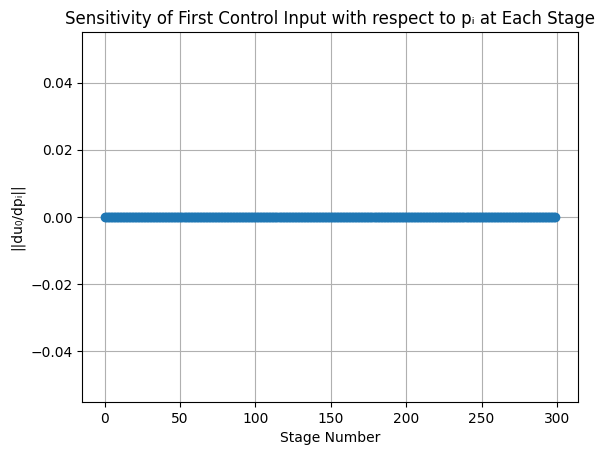

In [ ]:
# We will use the parametrized MPC instance (mpc_parametrized) for sensitivity analysis.
# Subsample the closed-loop state trajectory (e.g., every 'sample_step' state).
sample_step = 10
subsampled_states = [state for i, state in enumerate(x_traj) if i % sample_step == 0]
n_samples = len(subsampled_states)
print(f"Number of subsampled states for sensitivity analysis: {n_samples}")

# Sensitivity analysis parameters
epsilon = 1e-4          # Finite-difference perturbation size
N = opts.N              # Number of stages in the prediction horizon

# Initialize an array to accumulate sensitivity norms for each stage
sensitivity_accum = np.zeros(N)

# Loop over each subsampled state from the closed-loop simulation.
for x_state in subsampled_states:
    # For the given state, compute the baseline control input (with no parameter perturbation).
    p_base = np.zeros(N)
    u_base = mpc_parametrized.solve(x_state, p_base, pos_ref)
    
    # Loop over each stage in the horizon.
    for stage in range(N):
        # Create a copy of the baseline parameter vector and perturb the current stage.
        p_pert = np.copy(p_base)
        p_pert[stage] = epsilon
        
        # Compute the control input with the perturbed parameter vector.
        u_pert = mpc_parametrized.solve(x_state, p_pert, pos_ref)
        
        # Compute the finite-difference sensitivity (du/dp) approximation.
        sensitivity = (u_pert - u_base) / epsilon
        
        # Compute the norm of the sensitivity vector (control input is 2D).
        sensitivity_norm = np.linalg.norm(sensitivity)
        
        # Accumulate the sensitivity norm for this stage.
        sensitivity_accum[stage] += sensitivity_norm

# Average the sensitivity norms over all subsampled states.
average_sensitivity = sensitivity_accum / n_samples


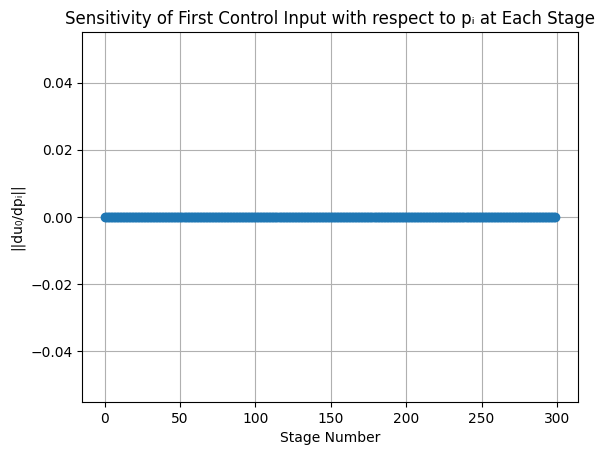

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import matplotlib.pyplot as plt

# Plot the averaged sensitivity norm versus the stage number.
plt.figure()
plt.plot(range(N), average_sensitivity, marker='o')
plt.xlabel('Stage Number')
plt.ylabel('Average Sensitivity Norm ||du₀/dpᵢ||')
plt.title('Averaged Sensitivity of First Control Input over Stages')
plt.grid(True)
plt.show()

print(average_sensitivity)